![thumbnail](https://user-images.githubusercontent.com/17668390/77380126-929c4380-6da4-11ea-9f4e-2489fe5e404e.png)

<h1><center><font size="6">Jigsaw Multilingual Toxic Comment Classification </font></center></h1>


In the previous 2018 [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge), Kagglers built multi-headed models to recognize toxicity and several subtypes of toxicity. In 2019, in the [Unintended Bias in Toxicity Classification Challenge](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification), aim was to build toxicity models that operate fairly across a diverse range of conversations. This year, [Jigsaw](https://jigsaw.google.com/) team are taking advantage of Kaggle's new TPU support and gives a challenging to build multilingual models with English-only training data.

# Acknowledgements

1. [Jigsaw TPU: DistilBERT with Huggingface and Keras](https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras) ~ by xhulu
2. [Jigsaw Multilingual Toxicity : EDA + Models](https://www.kaggle.com/tarunpaparaju/jigsaw-multilingual-toxicity-eda-models) ~ by Tarun Paparaju


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Preparing the Data for EDA</a>   
- <a href='#3'>Modeling</a>     
    - <a href='#32'>Model Definition</a>   
- <a href='#4'>End Note</a>
---

<html><font size=3 color='red'>If you like this notebook, please leave an UPVOTE. It motivates me to produce more quality content. Thank you.</font></html> ❤

# <a id='1'>Introduction</a>  

**What should We expect the data format to be?**

> The primary data for the competition is, in each provided file, the `comment_text` column. This contains the text of a comment which has been classified as `toxic` or non-toxic (0...1 in the toxic column). The train set’s comments are entirely in english and come either from Civil Comments or Wikipedia talk page edits. The test data's `comment_text` columns are composed of multiple non-English languages.
The `*-train.csv` files and `validation.csv` file also contain a toxic column that is the target to be trained on. 

> The `jigsaw-toxic-comment`-train.csv and `jigsaw-unintended-bias-train.csv` contain training data (`comment_text` and `toxic`) from the two previous Jigsaw competitions, as well as additional columns that you may find useful. `*-seqlen128.csv` files contain training, validation, and test data that has been processed for input into BERT.

**What will be We predicting?**

> You are predicting the probability that a comment is `toxic`. A toxic comment would receive a `1.0`. A benign, `non-toxic` comment would receive a `0.0`. In the `test set`, all comments are classified as either a `1.0` or a `0.0`.

In [1]:
!pip install -q googletrans
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
import re

import transformers
import tensorflow as tf
from tqdm.notebook import tqdm
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tokenizers import BertWordPieceTokenizer
from kaggle_datasets import KaggleDatasets
from googletrans import Translator
from colorama import Fore, Back, Style, init
import plotly.graph_objects as go
translator = Translator()

from tensorflow.keras.layers import (Dense, Input, LSTM, Bidirectional, Activation, Conv1D, 
                                     GRU,Embedding, Flatten, Dropout, Add, concatenate, MaxPooling1D,
                                     GlobalAveragePooling1D,  GlobalMaxPooling1D, 
                                     GlobalMaxPool1D,SpatialDropout1D)

from tensorflow.keras import (initializers, regularizers, constraints, 
                              optimizers, layers, callbacks)

sns.set(style="darkgrid")

# <a id='2'>Preparing the Data for EDA</a> 

**Most Important Files**
- `jigsaw-toxic-comment-train.csv`:  data from [this competition ](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)
- `jigsaw-unintended-bias-train.csv`: data from [this competition](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification)
- `validation.csv`: comments from Wikipedia talk pages in different non-English languages
- `test.csv`: comments from Wikipedia talk pages in different non-English languages
- `sample_submission.csv`: a sample submission file in the correct format

In [2]:
dir = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification'

train_set1 = pd.read_csv(os.path.join(dir, 'jigsaw-toxic-comment-train.csv'))
train_set2 = pd.read_csv(os.path.join(dir, 'jigsaw-unintended-bias-train.csv'))
train_set2.toxic = train_set2.toxic.round().astype(int)

valid = pd.read_csv(os.path.join(dir, 'validation.csv'))
test = pd.read_csv(os.path.join(dir, 'test.csv'))

In [3]:
# Combine train1 with a subset of train2
train = pd.concat([
    train_set1[['comment_text', 'toxic']],
    train_set2[['comment_text', 'toxic']].query('toxic==1'),
    train_set2[['comment_text', 'toxic']].query('toxic==0').sample(n=100000, random_state=0)
])

In [4]:
print(train.shape)
train.head()

(435775, 2)


,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
print(valid.shape)
valid.head()

(8000, 4)


,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [6]:
print(test.shape)
test.head()

(63812, 3)


,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


## Columns

And so we observe following columns so far.

- `id` - identifier within each file.
- `comment_text` - the text of the comment to be classified.
- `lang` - the language of the comment.
- `toxic` - whether or not the comment is classified as toxic. (Does not exist in `test.csv`.)

0    302165
1    133610
Name: toxic, dtype: int64


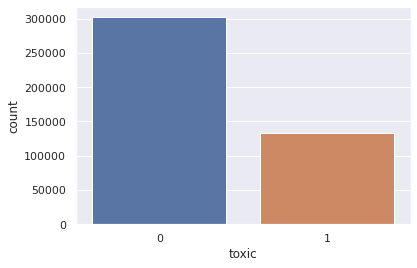

In [7]:
print(train.toxic.value_counts())
sns.countplot(train.toxic)

0    6770
1    1230
Name: toxic, dtype: int64


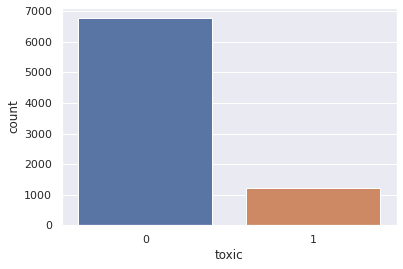

In [8]:
print(valid.toxic.value_counts())
sns.countplot(valid.toxic)

tr    3000
es    2500
it    2500
Name: lang, dtype: int64


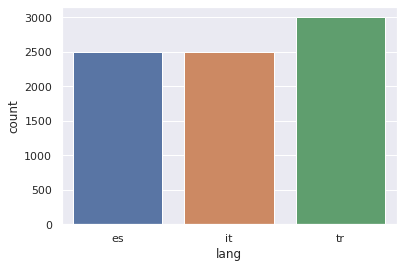

In [9]:
print(valid.lang.value_counts())
sns.countplot(valid.lang)

tr    14000
pt    11012
ru    10948
fr    10920
it     8494
es     8438
Name: lang, dtype: int64


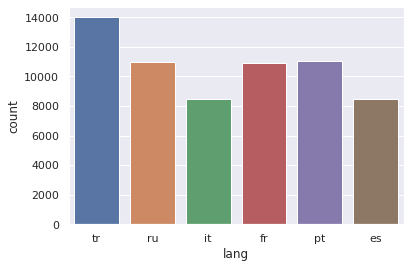

In [10]:
print(test.lang.value_counts())
sns.countplot(test.lang)

****
## Distribution of Characters & Words

In [11]:
def get_ax(rows=1, cols=2, size=7):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return fig, ax

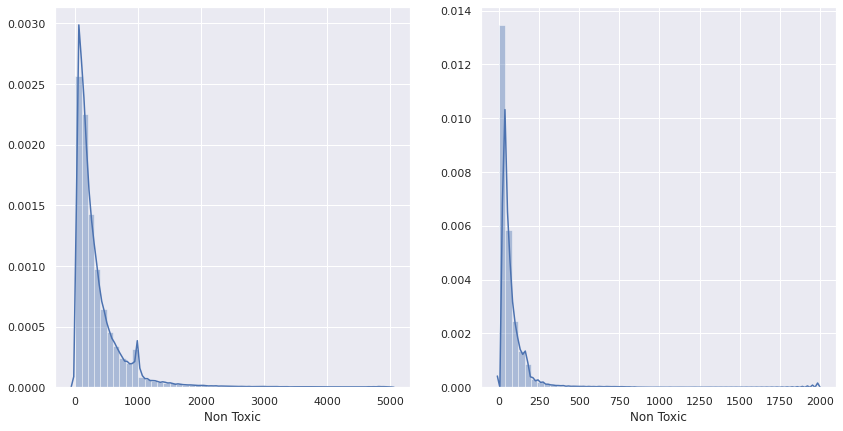

In [12]:
fig, ax = get_ax()

sns.distplot(train[train['toxic']==0]['comment_text'].str.len(), axlabel="Non Toxic", ax=ax[0])
sns.distplot(train[train['toxic']==0]['comment_text'].str.split().str.len(), axlabel="Non Toxic", ax=ax[1])

fig.show()

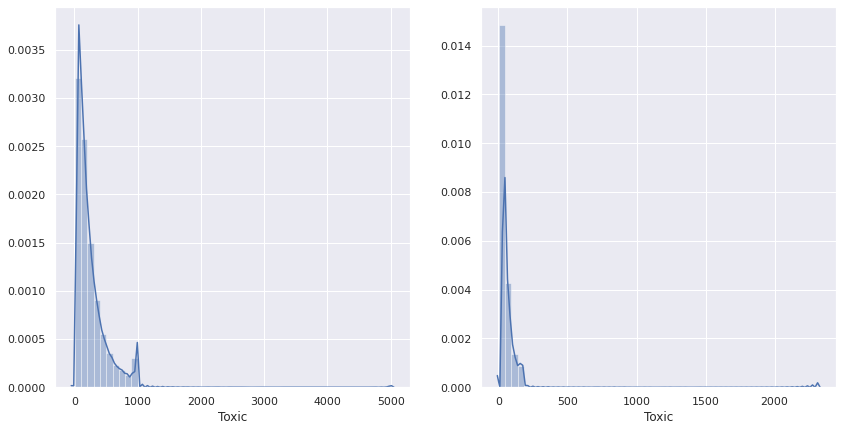

In [13]:
fig, ax = get_ax()

sns.distplot(train[train['toxic']==1]['comment_text'].str.len(), axlabel="Toxic", ax=ax[0])
sns.distplot(train[train['toxic']==1]['comment_text'].str.split().str.len(), axlabel="Toxic", ax=ax[1])

fig.show()

## Wordclouds - Frequent Words

In [14]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

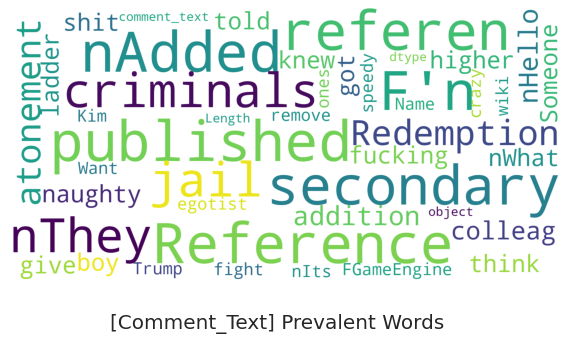

In [15]:
show_wordcloud(train['comment_text'].sample(20000), 
               title = '[Comment_Text] Prevalent Words')

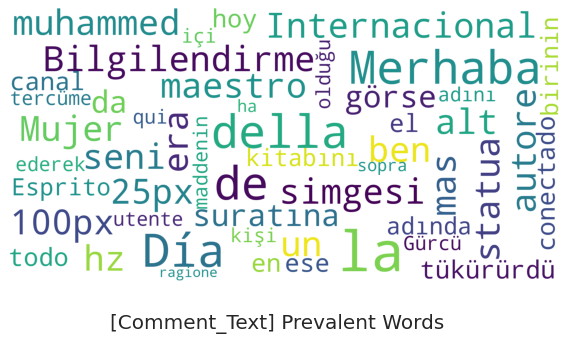

In [16]:
show_wordcloud(valid['comment_text'].sample(1000), 
               title = '[Comment_Text] Prevalent Words')

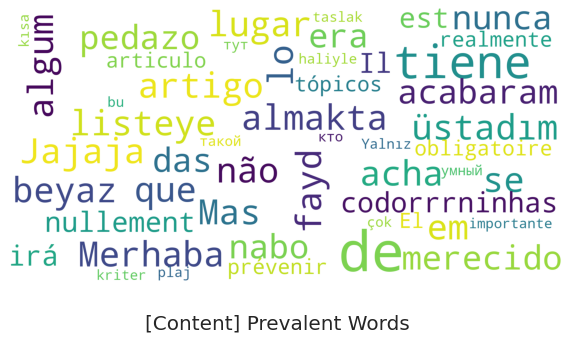

In [17]:
show_wordcloud(test['content'].sample(1000), 
               title = '[Content] Prevalent Words')

## Comments

Let's see top first comment text from the training set 1.

In [18]:
for i in range(5):
    print(f'[CONTENT {i}]\n', train['comment_text'][i])
    print()

[CONTENT 0]
 0    Explanation\nWhy the edits made under my usern...
0    This is so cool. It's like, 'would you want yo...
Name: comment_text, dtype: object

[CONTENT 1]
 D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)

[CONTENT 2]
 Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.

[CONTENT 3]
 "
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.

There appears to be a backl

# <a id='3'>Modeling</a> 

Here I will be following [xhlulu](https://www.kaggle.com/xhlulu) approach. Appreciate his effort if you his notebook.

In [19]:
# fast encoder
def fast_encode(texts, tokenizer, chunk_size=240, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [20]:
# general encoder
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    return np.array(enc_di['input_ids'])

**TPU Configs**

In [21]:
AUTO = tf.data.experimental.AUTOTUNE

# Create strategy from tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Configuration
EPOCHS = 4
BATCH_SIZE = 16* strategy.num_replicas_in_sync
MODEL = 'jplu/tf-xlm-roberta-large'
MAX_LEN = 224

In [22]:
# https://huggingface.co/models
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

#First load the real tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

**Create fast tokenizer**

In [23]:
%%time

x_train = regular_encode(train.comment_text.values, 
                         tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(valid.comment_text.values, 
                         tokenizer, maxlen=MAX_LEN)
x_test = regular_encode(test.content.values, tokenizer, 
                        maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values

CPU times: user 7min 13s, sys: 2.26 s, total: 7min 16s
Wall time: 7min 15s


**Build datasets objects**

In [24]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

We will use `focal loss` as our loss function.

In [25]:
from tensorflow.keras import backend as K

def label_smoothing(y_true,y_pred):
     return tf.keras.losses.binary_crossentropy(y_true,y_pred,label_smoothing=0.15)

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

**Load model into the TPU**

In [26]:
def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    
    cls_token = sequence_output[:, 0, :]
    x = Dropout(0.3)(cls_token)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss=label_smoothing,
                  metrics=[tf.keras.metrics.AUC()]) # competition metrics
    
    return model

In [27]:
import tensorflow.keras.backend as K

with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 224)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 224, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 559,891,457
Trainable params: 559,891,457
Non-trainable params: 0
_________________________________________________________________


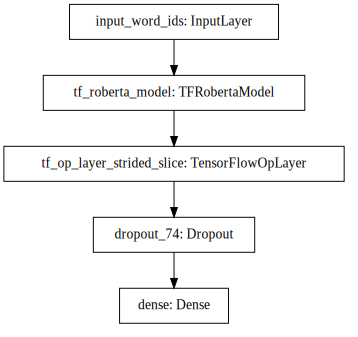

In [28]:
from IPython.display import SVG
SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

## Train Model

In [29]:
def callback():
    cb = []
    """
    Model-Checkpoint
    """
    checkpoint = callbacks.ModelCheckpoint('model.h5',
                                       save_best_only=True, 
                                       mode='min',
                                       monitor='val_loss', #  
                                       save_weights_only=True, verbose=0)

    cb.append(checkpoint)
    
    # Callback that streams epoch results to a csv file.
    log = callbacks.CSVLogger('log.csv')
    cb.append(log)

    return cb

In [30]:
calls = callback()
n_steps = x_train.shape[0] // BATCH_SIZE

train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    callbacks = calls,
    epochs=EPOCHS
)

Train for 3404 steps, validate for 63 steps
Epoch 1/4


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning:

Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning:

Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.



3404/3404 [==============================] - 2010s 590ms/step - loss: 0.3136 - auc: 0.9901 - val_loss: 0.5176 - val_auc: 0.8429
Epoch 2/4
3404/3404 [==============================] - 1802s 529ms/step - loss: 0.2960 - auc: 0.9965 - val_loss: 0.4992 - val_auc: 0.8551
Epoch 3/4
3404/3404 [==============================] - 1793s 527ms/step - loss: 0.2922 - auc: 0.9973 - val_loss: 0.5203 - val_auc: 0.8026
Epoch 4/4
3404/3404 [==============================] - 1791s 526ms/step - loss: 0.2885 - auc: 0.9976 - val_loss: 0.4996 - val_auc: 0.7963


In [31]:
# repeat the training on validaton set 
# the intuition behind such operation is to tweak the model parameter for non-english 
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS
)

Train for 62 steps
Epoch 1/4


/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning:

Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.



62/62 [==============================] - 127s 2s/step - loss: 0.4096 - auc: 0.9083
Epoch 2/4
62/62 [==============================] - 147s 2s/step - loss: 0.3458 - auc: 0.9718
Epoch 3/4
62/62 [==============================] - 32s 523ms/step - loss: 0.3125 - auc: 0.9878
Epoch 4/4
62/62 [==============================] - 33s 525ms/step - loss: 0.3033 - auc: 0.9888


## Visualize the Model Performances

In [32]:
def visualize_model_preds(model, indices=[0, 17, 1, 24]):
    comments = valid.comment_text.loc[indices].values.tolist()
    preds = model.predict(x_valid[indices].reshape(len(indices), -1))

    for idx, i in enumerate(indices):
        if y_valid[i] == 0:
            label = "Non-toxic"
            color = f'{Fore.GREEN}'
            symbol = '\u2714'
        else:
            label = "Toxic"
            color = f'{Fore.RED}'
            symbol = '\u2716'

        print('{}{} {}'.format(color, str(idx+1) + ". " + label, symbol))
        print(f'{Style.RESET_ALL}')
        print("ORIGINAL")
        print(comments[idx]); print("")
        print("TRANSLATED")
        print(translator.translate(comments[idx]).text)
        fig = go.Figure()
        if list.index(sorted(preds[:, 0]), preds[idx][0]) > 1:
            yl = [preds[idx][0], 1 - preds[idx][0]]
        else:
            yl = [1 - preds[idx][0], preds[idx][0]]
        fig.add_trace(go.Bar(x=['Non-Toxic', 'Toxic'], y=yl, marker=dict(color=["seagreen", "indianred"])))
        fig.update_traces(name=comments[idx])
        fig.update_layout(xaxis_title="Labels", yaxis_title="Probability", template="plotly_white", title_text="Predictions for validation comment #{}".format(idx+1))
        fig.show()
        
visualize_model_preds(model)

1. Non-toxic ✔

ORIGINAL
Este usuario ni siquiera llega al rango de    hereje   . Por lo tanto debería ser quemado en la barbacoa para purificar su alma y nuestro aparato digestivo mediante su ingestión.    Skipe linkin 22px   Honor, valor, leltad.      17:48 13 mar 2008 (UTC)

TRANSLATED
This user does not even rank heretic. Therefore it should be burned at the barbecue to purify his soul and our digestive tract by ingestion. Skipe linkin 22px Honor, courage, leltad. 13 Mar 2008 17:48 (UTC)


2. Toxic ✖

ORIGINAL
In riguardo a cio  che ho pubblicato e tu hai già tolto dai maroni. Lo trovo ingiusto e un po  comunista. sei pregato di non scassarmi il cazzo, e te lo chiedo gentilemnte. 

TRANSLATED
In regard to what I posted and you've already removed from the Maronites. I find it unfair and a little Communist. please do not scassarmi cock, and I ask gentilemnte.


3. Non-toxic ✔

ORIGINAL
Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, nel fare cio .

TRANSLATED
The text of this item seems to be plagiarized directly from here. I guess there may be copyright issues in doing what.


4. Toxic ✖

ORIGINAL
RAZZA DI IDIOTI!!! Vi siete bevuti il cervello???? Cos è questa intromissione????? Le vostre beghe personali risolvetele nelle vostre pagine (personali)! In più, io ho votato per la cancellazione!!! Quindi andate a .....lo! 

TRANSLATED
BREED OF IDIOTS !!! Have you drunk the brain ???? What is this interference ????? Your personal quarrels risolvetele in your pages (personal)! In addition, I have voted for the cancellation !!! So go to it .....!


## Submission

In [33]:
sub = pd.read_csv(dir + '/sample_submission.csv')
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

499/499 [==============================] - 119s 239ms/step


---

Below are some of the promising models to try out. Most of them are not multilingual though. But we can leverage their capacity by translating the non-english text. However, `xlm-roberta`, `xlm` , `m-bert` , `multifit` are few name of multilingual models. But it would be really interesting to have a [language independent model](https://www.youtube.com/watch?v=U51ranzJBpY) using [Sentencepiece Tokenizer](https://www.aclweb.org/anthology/D18-2012/).

- [Universal Language Model FIne-Tuning ](chrome-extension://cbnaodkpfinfiipjblikofhlhlcickei/src/pdfviewer/web/viewer.html?file=https://arxiv.org/pdf/1801.06146.pdf)

- [RoBERTa](https://arxiv.org/abs/1907.11692) | [ALBERT](https://arxiv.org/abs/1909.11942) | [Generative Pre-Training (GPT)](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf)

- [XLNet](chrome-extension://cbnaodkpfinfiipjblikofhlhlcickei/src/pdfviewer/web/viewer.html?file=https://arxiv.org/pdf/1906.08237v2.pdf) | [Code](https://github.com/zihangdai/xlnet)

- [ERNIE](https://arxiv.org/pdf/1905.07129v3.pdf) | [Code](https://github.com/thunlp/ERNIE)

- [Text-to-Text Transfer Transformer (T5)](https://arxiv.org/pdf/1910.10683.pdf) | [Code](https://github.com/google-research/text-to-text-transfer-transformer)

- [Binary-Partitioning Transformer](https://arxiv.org/pdf/1911.04070v1.pdf) | [Code](https://github.com/yzh119/BPT)

- [Neural Attentive Bag-of-Entities Model for Text Classification](https://arxiv.org/pdf/1909.01259.pdf) | [Code](https://github.com/wikipedia2vec/wikipedia2vec/tree/master/examples/text_classification)

- [Rethinking Complex Neural Network Architectures for Document Classification](https://www.aclweb.org/anthology/N19-1408.pdf) | [Code](https://github.com/castorini/hedwig)

- [Reformer: The Efficient Transformer](https://arxiv.org/pdf/2001.04451.pdf) | [Code](https://github.com/google/trax/tree/master/trax/models/reformer)

- [ELECTRA](https://openreview.net/pdf?id=r1xMH1BtvB) | [Code](https://github.com/huggingface/transformers)